<a href="https://colab.research.google.com/github/shreyansh4532/EDI_VII/blob/main/Colorize_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Importing Libraries
from tensorflow.keras.utils import  array_to_img, img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
import numpy as np
import os
import random
import tensorflow as tf

In [3]:
X = []
train_path = '/content/drive/My Drive/col_Dataset/Train/'
for imagename in os.listdir(train_path):
    X.append(img_to_array(load_img(train_path + imagename, target_size=(256, 256))))
print(f"Loaded {len(X)} images.")
X = np.array(X, dtype=float)

Loaded 840 images.


In [4]:
# For Checking purpose
print(f"Loaded {len(X)} images.")

Loaded 840 images.


In [5]:
# Set up train and test data
split = int(0.95*len(X))
Xtrain = X[:split]
Xtrain = 1.0/255*Xtrain

#set up Test data
Xtest = X[split:]
Xtest = 1.0/255*Xtest


In [6]:
#CNN model
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import Activation, Dense, Dropout, Flatten, InputLayer
from tensorflow.keras.layers import BatchNormalization
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import Adam

model = Sequential()

#Input Layer
model.add(Conv2D(64, (3, 3), input_shape=(256, 256, 1), activation='relu', padding='same'))
model.add(BatchNormalization())

#Hidden Layers
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())
model.add(Dropout(0.2))  # Dropout to prevent overfitting

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Dropout(0.3))  # Slightly higher dropout for deeper layers

model.add(Conv2D(128, (3, 3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu', padding='same', strides=2))
model.add(BatchNormalization())

model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())

model.add(Conv2D(2, (3, 3), activation='tanh', padding='same'))
model.add(UpSampling2D((2, 2)))

#Compiling the CNN
optimizer = Adam(learning_rate=1e-4)
model.compile(optimizer=optimizer, loss='mse', metrics = ['accuracy'])
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [7]:
# Image transformer
datagen = ImageDataGenerator(
        shear_range=0.2,
        zoom_range=0.2,
        rotation_range=20,
        horizontal_flip=True)

In [8]:
# Generate training data
batch_size = 10
def image_a_b_gen(batch_size):
    for batch in datagen.flow(Xtrain, batch_size=batch_size):
        lab_batch = rgb2lab(batch)
        X_batch = lab_batch[:,:,:,0]
        Y_batch = lab_batch[:,:,:,1:] / 128
        yield (X_batch.reshape(X_batch.shape+(1,)), Y_batch)

In [9]:
# Train model
tensorboard = TensorBoard(log_dir="/output/beta_run")
checkpoint = ModelCheckpoint("best_model.keras", monitor='loss', verbose=1, save_best_only=True, mode='min')
reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.5, patience=10, min_lr=1e-6, verbose=1)
trainedmodel = model.fit(image_a_b_gen(batch_size), callbacks=[tensorboard, checkpoint, reduce_lr],epochs=500, steps_per_epoch=30)

Epoch 1/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step - accuracy: 0.4971 - loss: 0.2999
Epoch 1: loss improved from inf to 0.18183, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 46s 246ms/step - accuracy: 0.4969 - loss: 0.2961 - learning_rate: 1.0000e-04
Epoch 2/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.5249 - loss: 0.0398
Epoch 2: loss improved from 0.18183 to 0.03461, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 8s 285ms/step - accuracy: 0.5248 - loss: 0.0396 - learning_rate: 1.0000e-04
Epoch 3/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 992ms/step - accuracy: 0.5357 - loss: 0.0252
Epoch 3: loss improved from 0.03461 to 0.02295, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.5358 - loss: 0.0251 - learning_rate: 1.0000e-04
Epoch 4/500
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step - accuracy: 0.5319 - loss: 0.0187
Epoch 4: loss improved from 0.02295 to 0.01932, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━

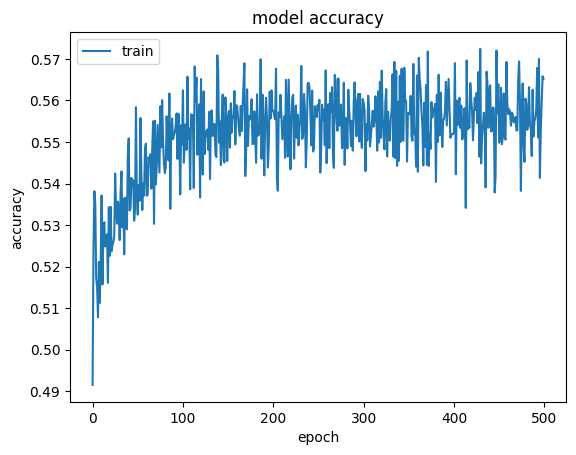

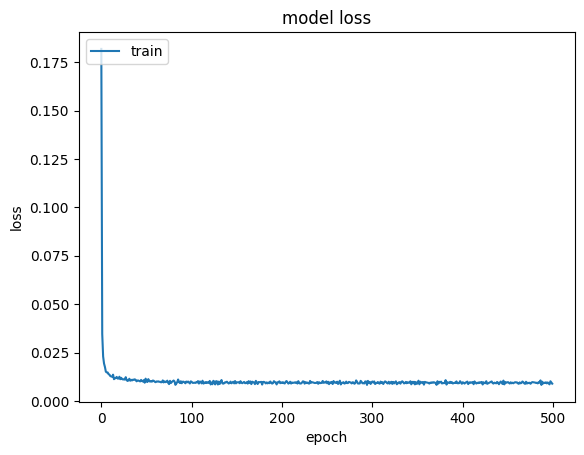

In [10]:
# Summarize history for model accuracy
plt.plot(trainedmodel.history['accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for model loss
plt.plot(trainedmodel.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [11]:
# Save model
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.weights.h5")

# load json and create model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.weights.h5")
loaded_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 256, 256, 64)        │             640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 256, 256, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 128, 128, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128, 128, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128, 128, 128)       │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128, 128, 128)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 64, 64, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 64, 64, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 64, 64, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 32, 32, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 32, 32, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 32, 32, 512)         │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 32, 32, 256)         │       1,179,904 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 32, 32, 256)         │           1,0

 Total params: 11,691,688 (44.60 MB)

 Trainable params: 3,895,970 (14.86 MB)

 Non-trainable params: 3,776 (14.75 KB)

 Optimizer params: 7,791,942 (29.72 MB)

In [12]:
# Test images
loaded_model.compile(optimizer=optimizer, loss='mse', metrics = ['accuracy'])
Xtest = rgb2lab(1.0/255*X[split:])[:,:,:,0]
Xtest = Xtest.reshape(Xtest.shape+(1,))
Ytest = rgb2lab(1.0/255*X[split:])[:,:,:,1:]
Ytest = Ytest / 128
print(loaded_model.evaluate(Xtest, Ytest, batch_size=10))

5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 862ms/step - accuracy: 0.5305 - loss: 0.0082
[0.00812428630888462, 0.5335155725479126]


In [13]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step


<ipython-input-14-1c8ce74aa3e8>:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 62 negative Z values that have been clipped to zero
  colorized_image = lab2rgb(cur)
<ipython-input-14-1c8ce74aa3e8>:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 24 negative Z values that have been clipped to zero
  colorized_image = lab2rgb(cur)
<ipython-input-14-1c8ce74aa3e8>:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 155 negative Z values that have been clipped to zero
  colorized_image = lab2rgb(cur)
<ipython-input-14-1c8ce74aa3e8>:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 18 negative Z values that have been clipped to zero
  colorized_image = lab2rgb(cur)
<ipython-input-14-1c8ce74aa3e8>:53: UserWarning: Conversion from CIE-LAB, via XYZ to sRGB color space resulted in 20 negative Z values that have been clipped to zero
  colorized_image = lab2rgb(cur)
<ipy

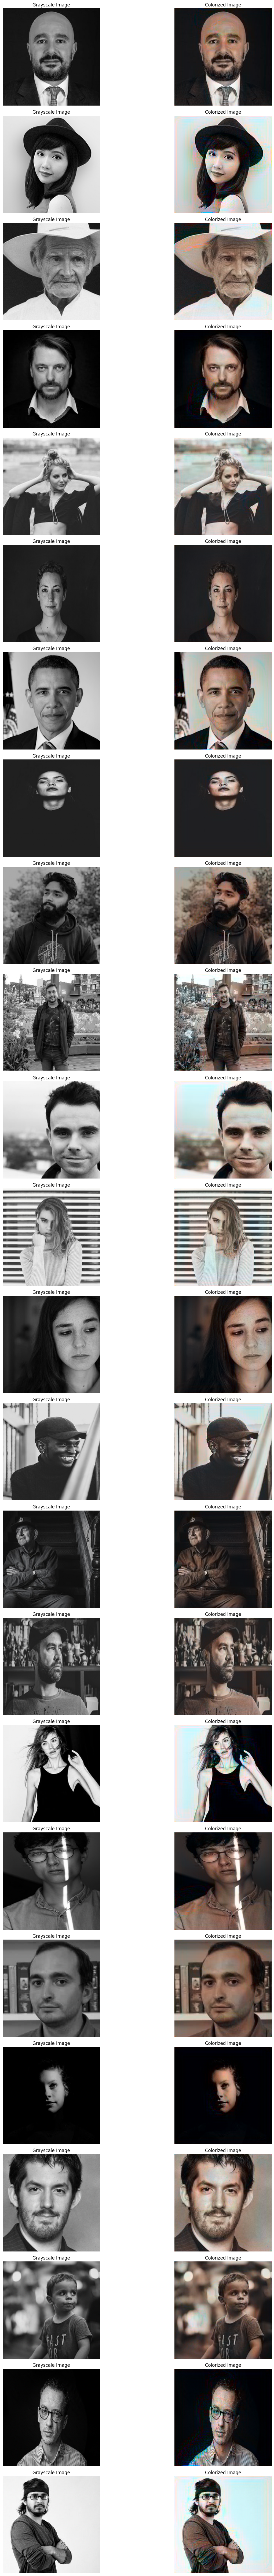

In [14]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import rgb2lab, lab2rgb

# Path to the test dataset
testpath = '/content/drive/My Drive/col_Dataset/Test/'

# Load test images
colorize = []
test_files = [f for f in os.listdir(testpath) if os.path.isfile(os.path.join(testpath, f))]

for filename in test_files:
    img = cv2.imread(os.path.join(testpath, filename))

    # Check if image is valid
    if img is None:
        print(f"Couldn't read image {filename}. Skipping.")
        continue

    # Convert image to RGB and resize
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, (256, 256))
    colorize.append(img_resized)

# Convert test images to LAB format and extract the L channel
colorize = np.array(colorize, dtype=float)
colorize_lab = rgb2lab(1.0 / 255 * colorize)[:, :, :, 0]
colorize_lab = colorize_lab.reshape(colorize_lab.shape + (1,))  # Add channel dimension

# Predict AB channels using the model
output = loaded_model.predict(colorize_lab)
output *= 128  # Rescale output to original LAB range

# Visualization
rows = len(colorize)
fig, ax = plt.subplots(rows, 2, figsize=(16, rows * 4))
row = 0

for i in range(rows):
    # Grayscale (L channel) image
    ax[row, 0].imshow(colorize[i] / 255, cmap='gray')
    ax[row, 0].set_title("Grayscale Image")
    ax[row, 0].axis('off')

    # Combine L channel with predicted AB channels
    cur = np.zeros((256, 256, 3))
    cur[:, :, 0] = colorize_lab[i][:, :, 0]  # L channel
    cur[:, :, 1:] = output[i]  # Predicted AB channels

    # Convert LAB to RGB for visualization
    colorized_image = lab2rgb(cur)
    ax[row, 1].imshow(colorized_image)
    ax[row, 1].set_title("Colorized Image")
    ax[row, 1].axis('off')

    row += 1

plt.tight_layout()
plt.show()


In [15]:
# fig, ax = plt.subplots(24, 2, figsize=(16, 100))
# row = 0
# colorize = []

# print('Output of the Model')

# testpath = '/content/drive/My Drive/col_Dataset/Test/'
# for filename in os.listdir(testpath):
#     img = cv2.imread(testpath + filename)

#     # Check if image is read correctly
#     if img is None:
#         print(f"Couldn't read image {filename}. Skipping.")
#         continue

#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#     img_resized = cv2.resize(img, (256, 256))
#     colorize.append(img_resized)

#     ax[row, 0].imshow(cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB), interpolation='nearest')
#     row += 1

# colorize = np.array(colorize, dtype=float)
# colorize = rgb2lab(1.0/255 * colorize)[:, :, :, 0]
# colorize = colorize.reshape(colorize.shape + (1,))

In [16]:
# Test model
output = loaded_model.predict(colorize)
output *= 128

row = 0

# Output colorizations
for i in range(len(output)):
    cur = np.zeros((256, 256, 3))
    cur[:, :, 0] = colorize[i][:, :, 0]
    cur[:, :, 1:] = output[i]
    resImage = lab2rgb(cur)

    ax[row, 1].imshow(resImage, interpolation='nearest')
    row += 1


InvalidArgumentError: Graph execution error:

Detected at node convolution defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-16-31077daeb593>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 212, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op

  File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 901, in conv

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 256, in conv

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 244, in _conv_xla

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 231, in _conv

Depth of output must be a multiple of the number of groups: 64 vs 3

Stack trace for op definition: 
File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main
File "/usr/lib/python3.10/runpy.py", line 86, in _run_code
File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>
File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start
File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start
File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once
File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>
File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 377, in dispatch_queue
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 250, in wrapper
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 748, in __init__
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request
File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper
File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute
File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell
File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes
File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
File "<ipython-input-16-31077daeb593>", line 2, in <cell line: 2>
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 512, in predict
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 208, in one_step_on_data_distributed
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 198, in one_step_on_data
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/trainer.py", line 96, in predict_step
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/sequential.py", line 212, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 175, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/function.py", line 171, in _run_through_graph
File "/usr/local/lib/python3.10/dist-packages/keras/src/models/functional.py", line 560, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py", line 901, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 117, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/operation.py", line 46, in __call__
File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 156, in error_handler
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 243, in call
File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 233, in convolution_op
File "/usr/local/lib/python3.10/dist-packages/keras/src/ops/nn.py", line 901, in conv
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 256, in conv
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 244, in _conv_xla
File "/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py", line 231, in _conv

	 [[{{node convolution}}]]
	tf2xla conversion failed while converting __inference_one_step_on_data_354955[]. Run with TF_DUMP_GRAPH_PREFIX=/path/to/dump/dir and --vmodule=xla_compiler=2 to obtain a dump of the compiled functions.
	 [[StatefulPartitionedCall]] [Op:__inference_one_step_on_data_distributed_355094]